In [4]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA  # Updated import path
import pmdarima as pm  # Simplified import for auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Updated to use more modern and flexible date parsing
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
stock_data = pd.read_csv('data/COST.csv', sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data


,Open,High,Low,Close,Adjusted Close,Volume
Date,,,,,,
2019-03-07,218.13,219.390,216.2200,216.79,198.852454,3279102
2019-03-08,225.48,228.700,223.7700,227.82,208.969815,6782749
2019-03-11,227.53,229.910,227.0600,229.69,210.685088,3748431
2019-03-12,230.32,233.400,229.9000,232.96,213.684523,2647259
2019-03-13,234.25,237.450,232.9500,236.38,216.821547,2421178
...,...,...,...,...,...,...
2024-02-26,742.00,746.780,739.0001,745.35,745.350000,1707046
2024-02-27,746.00,746.640,741.3300,744.71,744.710000,1471310
2024-02-28,743.21,751.880,743.2100,747.96,747.960000,1364965


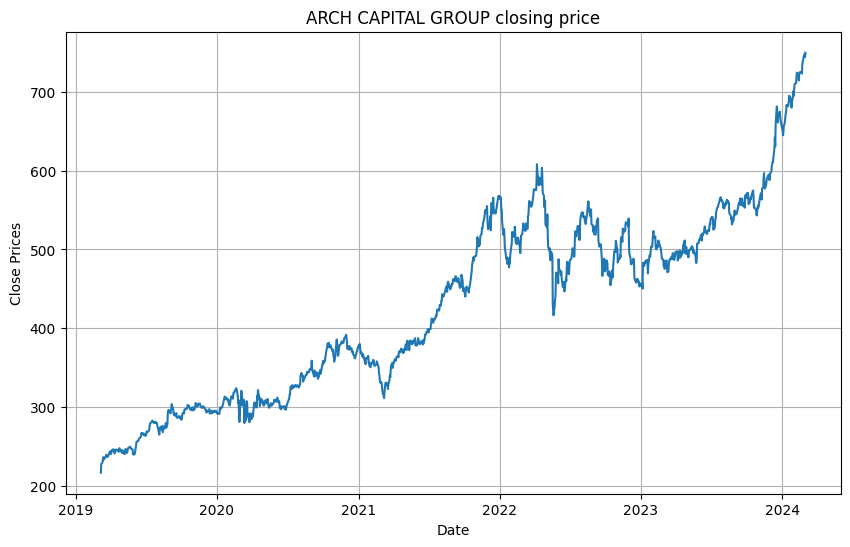

In [5]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()

<Axes: ylabel='Density'>

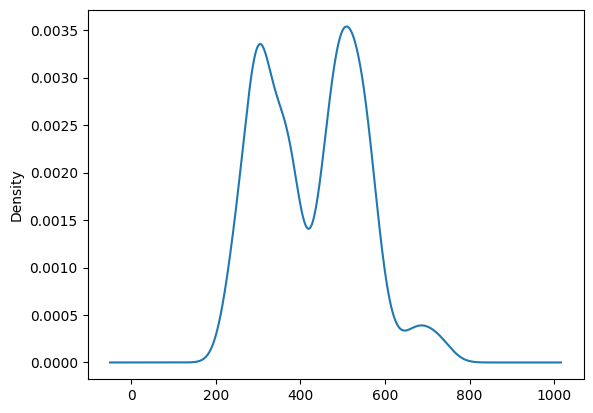

In [6]:
df_close = stock_data['Close']
df_close.plot(kind='kde')

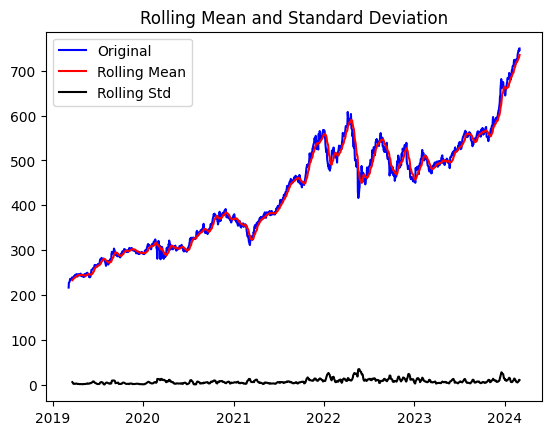

Results of Dickey-Fuller Test:
Test Statistics                  -0.037802
p-value                           0.955292
No. of lags used                 18.000000
Number of observations used    1237.000000
Critical value (1%)              -3.435647
Critical value (5%)              -2.863879
Critical value (10%)             -2.568015
dtype: float64


In [7]:
def test_stationarity(timeseries):
    # Determining rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    # Plot rolling statistics:
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of Dickey-Fuller Test:")
    adft = adfuller(timeseries, autolag='AIC')
    # Output for DFT
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, value in adft[4].items():
        output[f'Critical value ({key})'] = value
    print(output)
test_stationarity(df_close)


<Figure size 640x480 with 0 Axes>

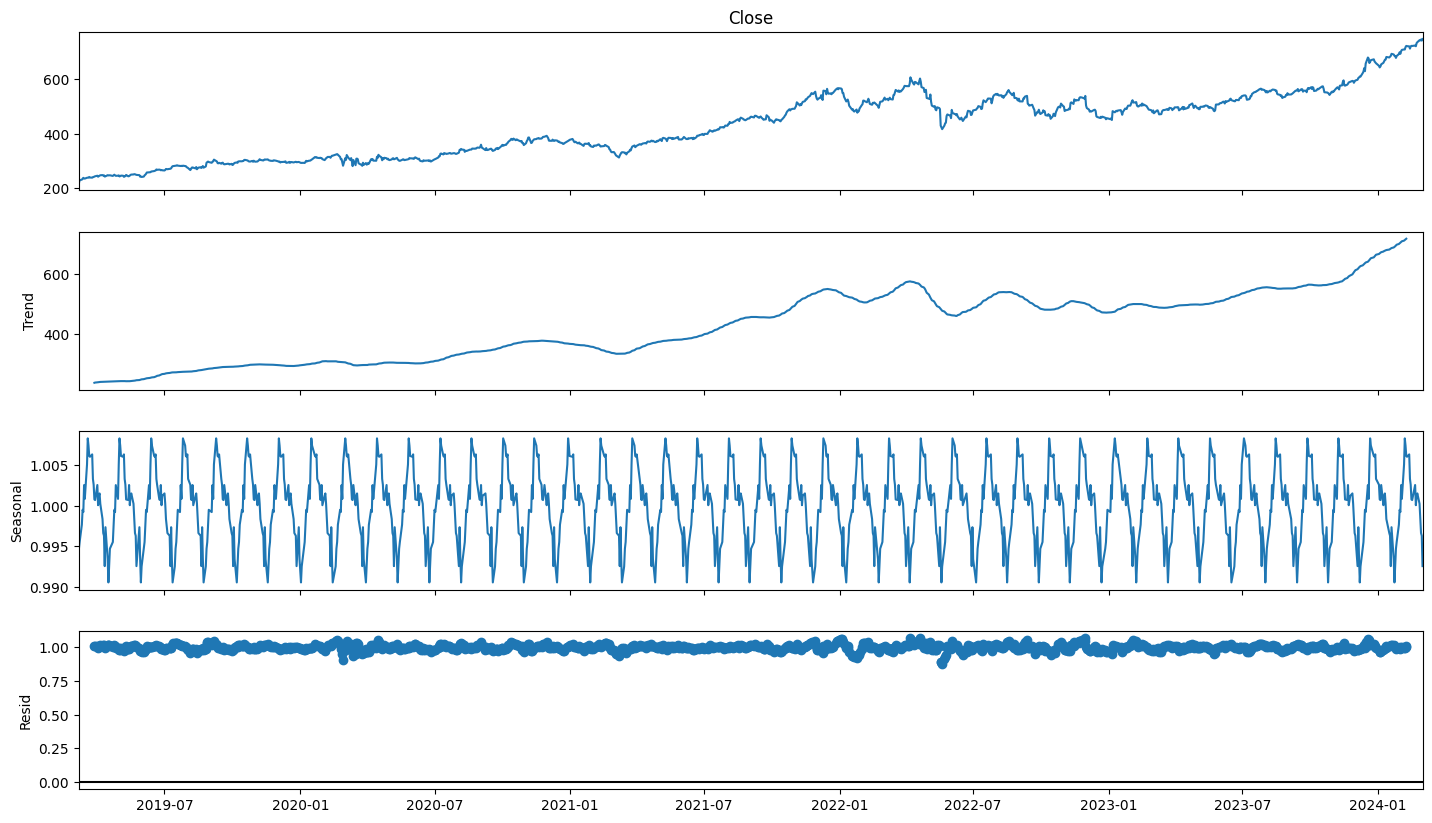

In [8]:
result = seasonal_decompose(df_close, model='multiplicative', period=30)  # Updated parameter
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


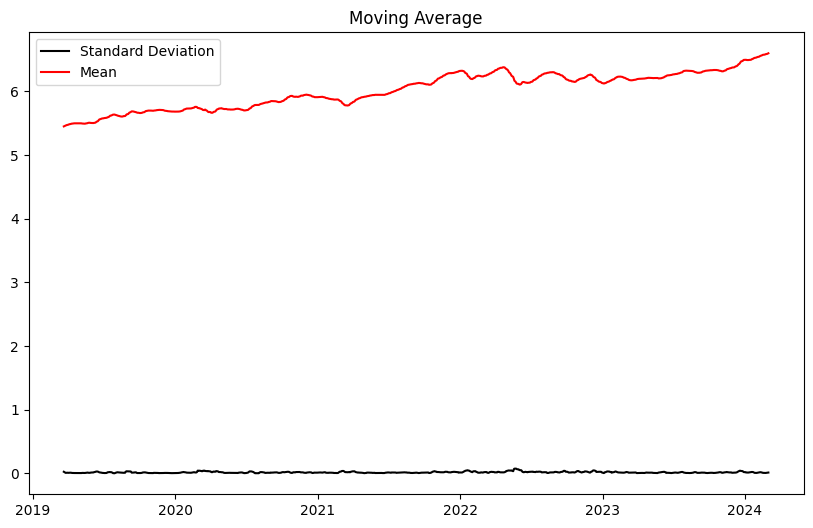

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color="black", label="Standard Deviation")
plt.plot(moving_avg, color="red", label="Mean")
plt.legend()
plt.show()


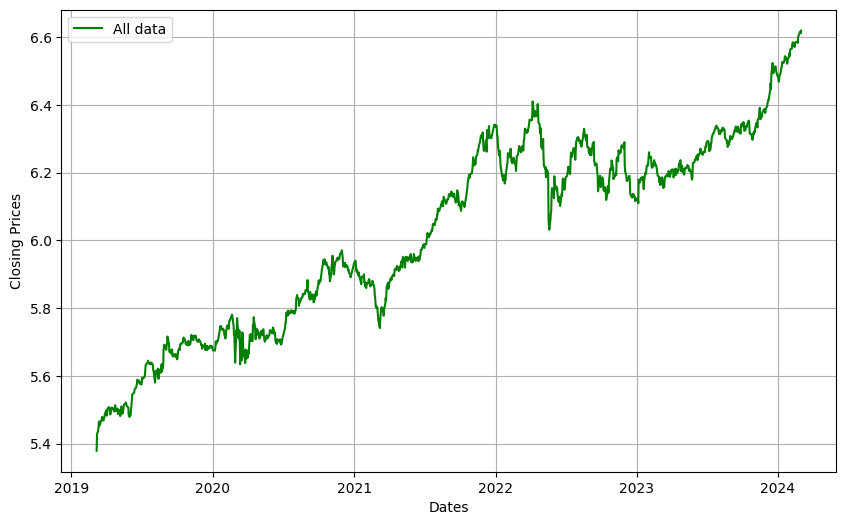

In [10]:
# Use all data for training
train_data = df_log
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='All data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6986.659, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6992.838, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6992.418, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6983.174, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6991.689, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6991.651, Time=0.56 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6989.603, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6988.460, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 2.118 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1256
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3499.419
Date:                Mon, 04 Mar 2024   AIC                          -6992.838
Time:                       

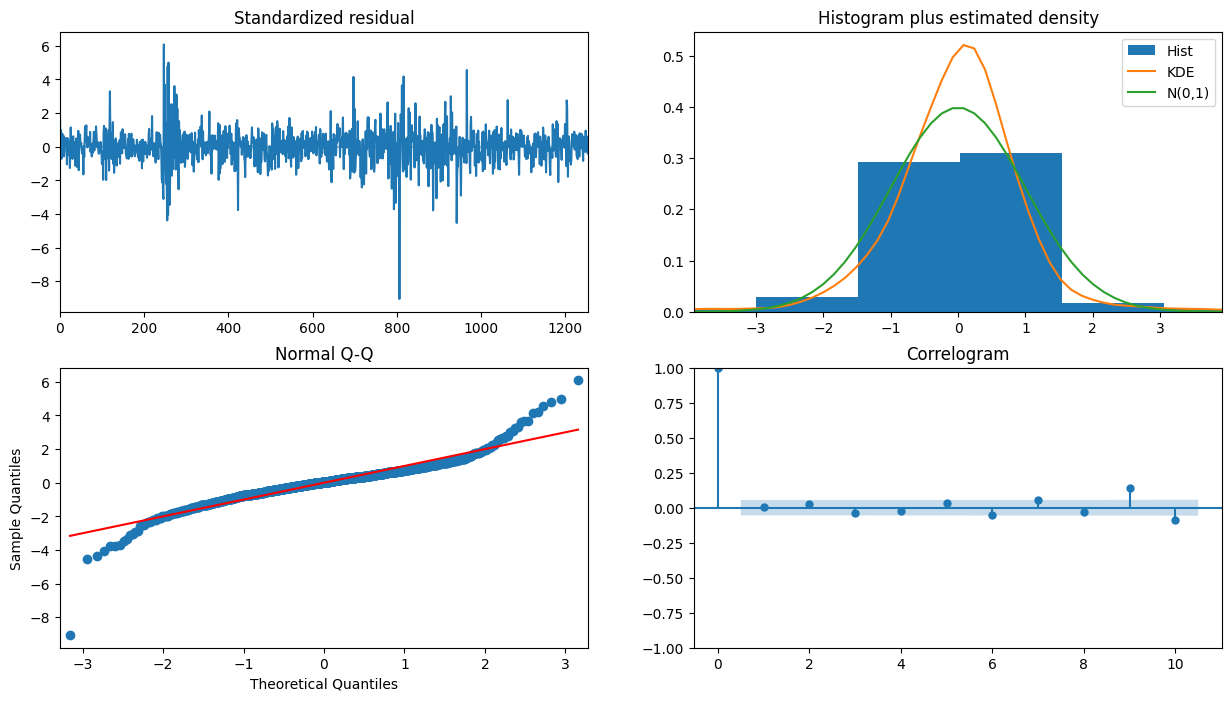

In [11]:
model_autoARIMA = pm.auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # Use adftest to find optimal 'd'
                      max_p=3, max_q=3, # Maximum p and q
                      m=1,              # Frequency of series
                      d=None,           # Let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()


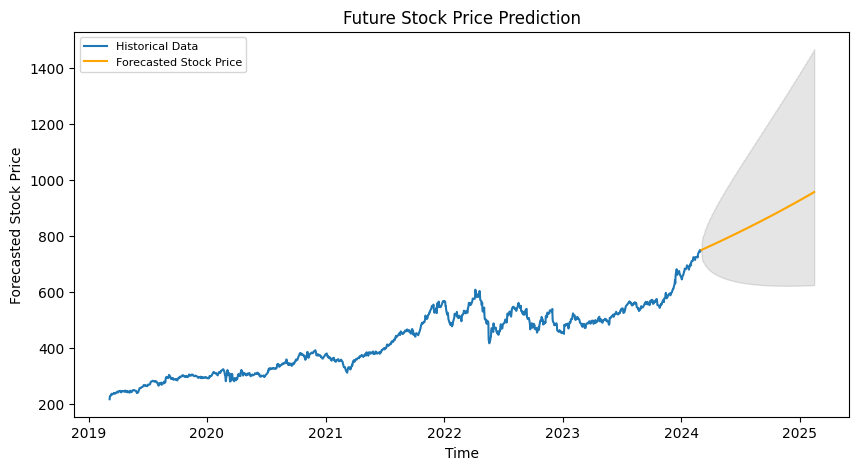

In [12]:
import numpy as np

# Fit the model to all available data (assuming df_log is the entire logged dataset)
fitted_model = model_autoARIMA.fit(df_log)

# Define the number of future periods and generate the date range for the forecast
n_periods = 250
last_date = df_log.index[-1]
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=n_periods, freq='B')

# Forecast
fc, conf_int = fitted_model.predict(n_periods=n_periods, return_conf_int=True)

# Convert the forecast and confidence intervals back to the original scale
fc_series = np.exp(fc)
lower_series = np.exp(conf_int[:, 0])
upper_series = np.exp(conf_int[:, 1])

# Create the forecast series and align it with the future_dates
fc_series = fc_series.set_axis(future_dates)
lower_series = pd.Series(lower_series, index=future_dates)
upper_series = pd.Series(upper_series, index=future_dates)

# Plot the forecast with confidence intervals
plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(df_log), label='Historical Data')  # Convert the historical data back to the original scale
plt.plot(fc_series, color='orange', label='Forecasted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('Future Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Forecasted Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [13]:
len(fitted_model)

TypeError: object of type 'ARIMA' has no len()

In [19]:
sp500_df = pd.read_csv('data/SP_500.csv')
sp500_df[149:]

,Symbol,Name,Sector
149,DISCK,Discovery (Series C),Communication Services
150,DISH,Dish Network,Communication Services
151,DG,Dollar General,Consumer Discretionary
152,DLTR,Dollar Tree,Consumer Discretionary
153,D,Dominion Energy,Utilities
...,...,...,...
500,YUM,Yum! Brands,Consumer Discretionary
501,ZBRA,Zebra Technologies,Information Technology
502,ZBH,Zimmer Biomet,Health Care
503,ZION,Zions Bancorp,Financials
